In [2]:
import pandas as pd 
import numpy as np 
import gc
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
def trim_categories(df, cols_list):
    for col in cols_list:
        df[col].cat.rename_categories(df[col].cat.categories.astype('str').str.strip(), inplace=True)

### Import data, setting dtype to save memory

In [3]:
levels_keep_cols = ['TankId', 'TankLevelPercent', 'TankLevelGallons', 'ExactFuelEventId']
levels_col_types = {'TankId': 'category',
             'ExactFuelEventId': 'uint64',
             'TankLevelPercent': 'float32',
             'TankLevelGallons': 'float32'}
#Rows with TankId == '2' are dropped on read-in, after being manually identified
levels_fueltank_df = pd.read_csv('data/Extranet2.ExactFuelTankLevels.csv', 
                                 skiprows=[48671, 1824800, 4579415, 5656381],
                                 usecols = levels_keep_cols, 
                                 dtype=levels_col_types ).drop(
    ['TankId'], axis=1)

#levels_fueltank_df = levels_fueltank_df.set_index('ExactFuelEventId').drop(['TankId'], axis=1)

#### Fuel Optimization data; only need tank capacity

In [4]:
optimization_fuel_df = pd.read_csv('data/BGEIDSC.EF2EFFP.csv',
                                   dtype={'TANKCAP': 'uint16', 'TRUCK' : 'category'},
                                  usecols = ['TRUCK', 'TANKCAP'])
optimization_fuel_df.columns = [s.lower() for s in optimization_fuel_df.columns]
trim_categories(optimization_fuel_df, ['truck'])

In [5]:
optimization_fuel_df.tankcap.value_counts()

200    510
230    180
250    132
235     10
120      4
Name: tankcap, dtype: int64

In [6]:
optimization_fuel_df.truck.cat.categories

Index(['1', '243', '244', '245', '246', '274', '301', '302', '303', '304',
       ...
       '2168', '2169', '2170', '2171', '2172', '2173', '2174', '2175', '2176',
       '9999'],
      dtype='object', length=836)

In [7]:
optimization_fuel_df.truck[optimization_fuel_df.truck == '1712']

347    1712
Name: truck, dtype: category
Categories (836, object): [1, 243, 244, 245, ..., 2174, 2175, 2176, 9999]

In [8]:
units_df = pd.read_csv('data/IBGEFILE.UNITS.csv', 
                       dtype = {'UNMAKE': 'category', 
                               'UNUNIT': 'category'})

units_df.columns = ['unit_number', 'model_year', 'make'] 

#Can drop non-int units
#units_df.unit_number = pd.to_numeric(units_df.unit_number, errors = 'coerce')
#units_df = units_df[units_df.unit_number != 1].dropna()
#Make units category variable
#units_df['unit_number'] = units_df.unit_number.astype('category')


# Trim white space from category strings 
trim_categories(units_df, ['make', 'unit_number'])

# Remove invalid entries
units_df = units_df[units_df.unit_number.isin(['ZEBE', 'CCTRK', 'BGXL', '1']) == False]

# Fix typos
units_df.make[units_df.make.isin(['KENOWRTH', 'KEWORTH'])] = 'KENWORTH'

In [9]:
units_df.unit_number.cat.categories

Index(['1', '121', '1505', '1506', '1507', '1508', '1509', '1510', '1511',
       '1512',
       ...
       '535', '536', '537', '538', '539', '540', '816', 'BGXL', 'CCTRK',
       'ZEBE'],
      dtype='object', length=708)

In [10]:
units_df.make.cat.categories

Index(['', 'FREIGHTLINER', 'KENOWRTH', 'KENWORTH', 'KEWORTH', 'MACK',
       'PETERBILT', 'SYSTEM TEST', 'VOLVO'],
      dtype='object')

In [76]:
units_df.make.value_counts()

KENWORTH        526
VOLVO           139
FREIGHTLINER     15
PETERBILT        14
MACK             10
SYSTEM TEST       0
KEWORTH           0
KENOWRTH          0
                  0
Name: make, dtype: int64

In [12]:
transaction_df_cols = ['tr_id', 'tr_date', 'tr_time', 'tr_station_id', 'tr_station_name',
                         'tr_station_cty', 'tr_station_st', 'tr_drvr_code', 'tr_unit_id', 
                         'tr_item_cd1', 'tr_item_qty1', 'tr_item_cd2', 'tr_item_qty2',
                          'tr_item_cd3', 'tr_item_qty3', 'tr_item_cd4', 'tr_item_qty4',
                          'tr_item_cd5', 'tr_item_qty5', 'tr_item_cd6', 'tr_item_qty6']
tr_dtypes= {'tr_id' : 'category',  
            'tr_date' : 'uint32', 
            'tr_time' : 'uint32', 
            'tr_station_id' : 'category', 
            'tr_station_name' : 'category', 
            'tr_station_cty' : 'category', 
            'tr_station_st' : 'category', 
            'tr_drvr_code' : 'category', 
            'tr_unit_id' : 'category', 
            'tr_item_cd1' : 'category', 
            'tr_item_qty1' : 'float32', 
            'tr_item_cd2' : 'category', 
            'tr_item_qty2' : 'float32', 
            'tr_item_cd3' : 'category', 
            'tr_item_qty3' : 'float32', 
            'tr_item_cd4' : 'category', 
            'tr_item_qty4' : 'float32', 
            'tr_item_cd5' : 'category', 
            'tr_item_qty5' : 'float32', 
            'tr_item_cd6' : 'category', 
            'tr_item_qty6' : 'float32'}
act_fuel_transactions = ['ULSD', 'FUEL', 'CDSL', 'DSL1', 'BDSL']
transaction_df = pd.read_csv('data/BGETCHDATA.PTCHTRANH.csv', names = transaction_df_cols, dtype = tr_dtypes, header=0 )

# Trim white space from category strings 
trim_categories(transaction_df, ['tr_station_id', 'tr_station_name',
                         'tr_station_cty', 'tr_station_st','tr_drvr_code','tr_unit_id','tr_item_cd1', 'tr_item_cd2', 'tr_item_cd3', 'tr_item_cd4', 'tr_item_cd5', 'tr_item_cd6' ])
transaction_df['tr_id'] = transaction_df.tr_id.cat.as_ordered()

#### Create datetime column in transactions_df

In [13]:
#confirm no junk data in this col (returns false if no NaNs)
None in transaction_df.tr_time

# 20170112 3

#Combine tr_date and tr_time into a single date time column
    #1. zero pad tr_time on left for interpretation as military time
        #cast tr_time as string
transaction_df.tr_time = transaction_df.tr_time.astype(str)

# 20170112 '3' Time column is now a string
#ensure none of my strings are over 4 digits in length
for s in transaction_df.tr_time:
    assert len(s) < 5

#check for blanks
'' in transaction_df.tr_time

#add zeros to the left until each cell is len 4
zero_padded_time = []
for s in transaction_df.tr_time:
    while len(s) < 4:
        s = '0' + s
    zero_padded_time.append(s)
# 20170112 '0003' zero padded minutes
#spot check
for s in zero_padded_time:
    assert len(s) == 4

transaction_df.tr_time = zero_padded_time

#append tr_date (as string) and tr_time together, and then convert them to dateime
#transaction_df.tr_datetime 
tst = [datetime.strptime(str(d) + 
                         t, '%Y%m%d%H%M') 
       for d, t in zip(transaction_df.tr_date,
                       transaction_df.tr_time)]
#love list comprehensions

transaction_df['tr_datetime'] = tst#assign

#drop superfluous columns
transaction_df.drop(['tr_date','tr_time'], axis = 'columns', inplace=True)
transaction_df.head()

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
0,42574765,520277,FLYING J VANDALIA 97,VANDALIA,OH,ULAL,1564,SCLE,1.000000,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 00:20:00
1,42575331,516202,PILOT NEW BRAUNFELS 330,NEW BRAUNFELS,TX,MANRI,1584,ULSD,137.399994,DEFD,7.71,CADV,1.0,,0.0,,0.0,,0.0,2017-01-01 00:48:00
2,42578678,516277,PILOT 421,DALTON,GA,RUSR,1713,ULSD,137.929993,DEFD,4.12,,0.0,,0.0,,0.0,,0.0,2017-01-01 01:34:00
3,42578722,231100,FJ-BRUNSWICK 627,BRUNSWICK,GA,FOSJA,1711,ULSD,45.000000,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 01:37:00
4,42579695,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HICWIL,1837,ULSD,107.360001,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 03:02:00


In [14]:
transaction_df.tr_item_cd2.value_counts()

        96333
DEFD    42468
CADV     8196
ADD       348
OIL       264
SCLE      236
UREA       15
WWFL        1
Name: tr_item_cd2, dtype: int64

In [16]:
# These rows are dropped
transaction_df[transaction_df.tr_unit_id.isin(['OFFICE', '']) == True]

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
1174,42977478,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,50.000000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-05 07:40:00
1383,43037746,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,130.570007,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-05 14:57:00
6812,44866479,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HILB,,ULSD,60.790001,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-21 06:08:00
6955,44908231,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HILB,,ULSD,30.440001,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-21 14:33:00
13493,47176337,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,96.269997,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-09 09:11:00
15203,47747773,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,62.840000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-14 10:46:00
16503,48174487,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,82.480003,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-17 11:53:00
16583,48198811,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,50.000000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-17 15:01:00
17310,48478526,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,1974,,ULSD,10.060000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-20 12:12:00
18077,48727766,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,88.010002,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-22 09:42:00


In [ ]:
# Drops Office and blank Unit IDs
#transaction_df = transaction_df[transaction_df.tr_unit_id.isin(['OFFICE', '      ']) == False]

#### Make df with just fuel transactions

In [17]:
fuel_trans_df = transaction_df[transaction_df.tr_item_cd1.isin(act_fuel_transactions)]

In [6]:
events_keep_cols = ['Id', 'EventTimeStamp', 'EquipmentID', 
                    'DriverID', 'Latitude', 'Longitude', 'LocationTimeStamp', 
                    'Speed', 'Odometer', 'IgnitionStatus', 'EFReportReason']
events_col_types = {'DriverID': 'category',
             'EFReportReason': 'category',
             'EquipmentID': 'category',
             'Id': 'uint64',
             'IgnitionStatus': 'category',
             'Latitude': 'float64',
             'Longitude': 'float64',
             'Odometer': 'float64',
             'Speed': 'uint16'}

events_levels_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', 
                             usecols=events_keep_cols, 
                            dtype=events_col_types, 
                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], 
                            infer_datetime_format=True).merge(
    levels_fueltank_df, copy=False, how='inner', left_on='Id', right_on='ExactFuelEventId')
trim_categories(events_levels_df, ['EquipmentID','DriverID','EFReportReason', 'IgnitionStatus' ])
events_levels_df = events_levels_df.merge(
    optimization_fuel_df, copy=False, how='left', left_on='EquipmentID', right_on = 'truck')

# EquipmentID needs to be turned back into a categorical after the join
events_levels_df['EquipmentID'] = events_levels_df['EquipmentID'].astype('category', copy=False)
trim_categories(events_levels_df, ['EquipmentID'])

gc.collect()

NameError: name 'levels_fueltank_df' is not defined

In [75]:
events_levels_df.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7908406 entries, 0 to 7908405
Data columns (total 16 columns):
Id                   7908406 non-null uint64
EventTimeStamp       7908406 non-null datetime64[ns]
EquipmentID          7908406 non-null category
DriverID             7798523 non-null category
Latitude             7908406 non-null float64
Longitude            7908406 non-null float64
LocationTimeStamp    7908406 non-null datetime64[ns]
Speed                7908406 non-null uint16
Odometer             7908406 non-null float64
IgnitionStatus       7908406 non-null category
EFReportReason       7908406 non-null category
TankLevelPercent     7908406 non-null float32
TankLevelGallons     7908406 non-null float32
ExactFuelEventId     7908406 non-null uint64
truck                7908406 non-null category
tankcap              7908406 non-null uint16
dtypes: category(5), datetime64[ns](2), float32(2), float64(3), uint16(2), uint64(2)
memory usage: 633.8 MB


In [56]:
events_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', 
                             usecols=events_keep_cols, 
                            dtype=events_col_types, 
                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], 
                            infer_datetime_format=True)
events_df.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8495130 entries, 0 to 8495129
Data columns (total 11 columns):
Id                   8495130 non-null uint64
EventTimeStamp       8495130 non-null datetime64[ns]
EquipmentID          8495130 non-null category
DriverID             8176188 non-null category
Latitude             8495130 non-null float64
Longitude            8495130 non-null float64
LocationTimeStamp    8495130 non-null datetime64[ns]
Speed                8495130 non-null uint16
Odometer             8495130 non-null float64
IgnitionStatus       8495130 non-null category
EFReportReason       8495130 non-null category
dtypes: category(4), datetime64[ns](2), float64(3), uint16(1), uint64(1)
memory usage: 453.8 MB


In [57]:
events_no_driver = events_df[events_df.DriverID.isnull()]
events_no_driver.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318942 entries, 60 to 8495110
Data columns (total 11 columns):
Id                   318942 non-null uint64
EventTimeStamp       318942 non-null datetime64[ns]
EquipmentID          318942 non-null category
DriverID             0 non-null category
Latitude             318942 non-null float64
Longitude            318942 non-null float64
LocationTimeStamp    318942 non-null datetime64[ns]
Speed                318942 non-null uint16
Odometer             318942 non-null float64
IgnitionStatus       318942 non-null category
EFReportReason       318942 non-null category
dtypes: category(4), datetime64[ns](2), float64(3), uint16(1), uint64(1)
memory usage: 19.6 MB


In [74]:
#events_no_driver.groupby('EquipmentID')
events_grp = events_no_driver.groupby(['EquipmentID', 'Latitude', 'Odometer'])
events_grp.size()
#counts().to_frame('rows')

EquipmentID  Latitude  Odometer
0            0.00000   0.0           920
                       7437.8          1
                       82241.1        80
             35.04675  508442.7        1
             35.04688  555073.7        1
             35.04694  514078.2        1
             35.04695  518939.8        1
             35.49170  0.0             1
             35.49171  0.0             1
             35.49173  0.0             2
             35.49178  0.0             2
             35.49179  0.0             1
                       470438.2        1
             35.49181  0.0             4
             35.49182  0.0             5
             35.49183  0.0            38
             35.49184  0.0            84
             35.49185  0.0            69
                       530754.0        2
             35.49186  0.0           203
                       501756.4        1
                       530754.0        4
             35.49187  0.0           208
                       53

In [48]:
extra_trans_drivers = [drvr for drvr in transaction_df.tr_drvr_code.cat.categories if not (drvr in events_levels_df.DriverID.cat.categories)]

In [54]:
len(extra_trans_drivers)

22

In [55]:
events_levels_df.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7908406 entries, 0 to 7908405
Data columns (total 16 columns):
Id                   7908406 non-null uint64
EventTimeStamp       7908406 non-null datetime64[ns]
EquipmentID          7908406 non-null category
DriverID             7798523 non-null category
Latitude             7908406 non-null float64
Longitude            7908406 non-null float64
LocationTimeStamp    7908406 non-null datetime64[ns]
Speed                7908406 non-null uint16
Odometer             7908406 non-null float64
IgnitionStatus       7908406 non-null category
EFReportReason       7908406 non-null category
TankLevelPercent     7908406 non-null float32
TankLevelGallons     7908406 non-null float32
ExactFuelEventId     7908406 non-null uint64
truck                7908406 non-null category
tankcap              7908406 non-null uint16
dtypes: category(5), datetime64[ns](2), float32(2), float64(3), uint16(2), uint64(2)
memory usage: 633.8 MB


In [53]:
events_levels_df.DriverID.value_counts().to_frame('counts').sort_values('counts').index

CategoricalIndex(['WALK', 'RYAC', 'DUNG', 'BRAMAT', 'EDNJ', 'OWEJE', 'SHOP!',
                  'WORJON', 'BIVD', 'HARJI',
                  ...
                  'PERT', 'CUNW', 'BROD03', 'BULR', 'CHAJO', 'ECKS', 'ULAL',
                  'VAUJAM', 'SIMJIM', 'DYET'],
                 categories=['36728', 'ABBV', 'ACHC', 'ADADE', 'ADAG', 'ADAR', 'ALBJ', 'ALBME', ...], ordered=False, dtype='category', length=948)

In [47]:
[truck for truck in events_levels_df.truck.cat.categories if truck in trucks_zero_rows[trucks_zero_rows == False] and not (
    truck in events_levels_df.EquipmentID.cat.categories) ]

[]

In [39]:
events_levels_df.EquipmentID.value_counts().to_frame('counts').sort_values('counts')
#events_levels_df.EquipmentID.values[:5]

,counts
1519,1
2156,2
1516,4
1636,7
1508,15
1621,16
1617,18
1635,28
1513,75
1628,106


In [43]:
#events_levels_df.truck.cat.categories.values[:5]
trucks_zero_rows = events_levels_df.truck.value_counts().to_frame('counts').sort_values('counts')['counts'] == 0
#trucks_zero_rows[trucks_zero_rows != True]
events_levels_df.truck.value_counts().to_frame('counts').sort_values('counts')

,counts
1,0
1371,0
1369,0
1357,0
1352,0
1348,0
1345,0
1341,0
1340,0
1336,0


In [14]:
'''events_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', 
                             usecols=events_keep_cols, 
                            dtype=events_col_types, 
                             index_col = 'EventTimeStamp',
                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], 
                            infer_datetime_format=True)
trim_categories(events_df, ['DriverID','EFReportReason', 'IgnitionStatus' ])
'''

In [78]:
perf_cols = ['Id', 'EventTimeStamp', 'EquipmentID', 'DriverID', 'IgnitionStatus', 'TripStatus',
       'DataStartTimeStamp', 'DataEndTimeStamp', 'Distance', 'DriveTime',
       'EngineTime', 'MoveTime', 'IntertripIdleTime', 'ShortIdleTime',
       'OverSpeedTime', 'TotalFuelUsed', 'IdleFuelUsed',
        'CruiseControlTime', 'TopGearTime',
       'GearDataSource', 'SpeedUnits', 'LocationTimeStamp', 'Latitude', 'Longitude', 
            'FaultFlag', 'RegisteredDriver']

perf_col_types = {'DriverID': 'category',
             'EFReportReason': 'category',
             'Id': 'uint64',
             'IgnitionStatus': 'category',
             'GearDataSource': 'category',
             'Latitude': 'float64',
             'Longitude': 'float64',
             'FaultFlag': 'category',
             'RegisteredDriver': 'category'}

performance_df = pd.read_csv('data/Extranet2.QCPerformanceExtracts.csv',
                             usecols=perf_cols, 
                            dtype=perf_col_types, 
                            parse_dates=['EventTimeStamp','LocationTimeStamp', 'DataStartTimeStamp','DataEndTimeStamp' ], 
                            infer_datetime_format=True)
# Remove invalid Truck IDs
performance_df = performance_df[performance_df.EquipmentID < 9999]

# Set EquipmentID to category 
performance_df['EquipmentID'] = performance_df.EquipmentID.astype('category')

# Trim white space from category strings 

trim_categories(performance_df, ['EquipmentID', 'DriverID'])

In [79]:
len(performance_df[performance_df.RegisteredDriver == 0].DriverID.value_counts())

812

In [80]:
df_names_list = ['events_levels_df', 'levels_fueltank_df', 'optimization_fuel_df',
                 'units_df', 'transaction_df', 'performance_df', 'fuel_trans_df']
df_list = [events_levels_df, levels_fueltank_df, optimization_fuel_df, 
           units_df, transaction_df, performance_df, fuel_trans_df]
df_dict = dict(zip(df_names_list, df_list))

for k, v in df_dict.items():
    print(k + ' shape: ' + str(v.shape))

print('unique EventTimeStamp values: ' + str(len(events_levels_df.EventTimeStamp.unique())))    
print('unique EventTimeStamp + EquipmentID values: ' + str(
events_levels_df.groupby(['EquipmentID', 'EventTimeStamp']).size().to_frame('events').shape[0]))
print('unique EventTimeStamp + DriverID values: ' + str(
events_levels_df.groupby(['DriverID', 'EventTimeStamp']).size().to_frame('events').shape[0]))
print('unique tr_datetime + tr_unit_id values: ' + str(
fuel_trans_df.groupby(['tr_unit_id', 'tr_datetime']).size().to_frame('transactions').shape[0]))
print('unique tr_datetime + driverID values: ' + str(
fuel_trans_df.groupby(['tr_drvr_code', 'tr_datetime']).size().to_frame('transactions').shape[0]))
print('unique tr_datetime values: ' + str(len(fuel_trans_df.tr_datetime.unique())))

events_levels_df shape: (7908406, 16)
levels_fueltank_df shape: (7908824, 3)
optimization_fuel_df shape: (836, 2)
units_df shape: (704, 3)
transaction_df shape: (147861, 20)
performance_df shape: (32253, 26)
fuel_trans_df shape: (104056, 20)
unique EventTimeStamp values: 7527560
unique EventTimeStamp + EquipmentID values: 7533080
unique EventTimeStamp + DriverID values: 7429057
unique tr_datetime + tr_unit_id values: 104055
unique tr_datetime + driverID values: 104055
unique tr_datetime values: 93782


### Two transactions share the same datetime + driver + truck; all other combinations of datetime and either driver or truck are unique

In [81]:
print(fuel_trans_df.groupby(['tr_drvr_code', 'tr_datetime']).size().to_frame('transactions').sort_values('transactions', ascending=False).head(1))
print(fuel_trans_df.groupby(['tr_unit_id', 'tr_datetime']).size().to_frame('transactions').sort_values('transactions', ascending=False).head(1))

                                  transactions
tr_drvr_code tr_datetime                      
CRAMI        2017-02-14 16:15:00             2
                                transactions
tr_unit_id tr_datetime                      
1795       2017-02-14 16:15:00             2


In [82]:
fuel_trans_df[fuel_trans_df.tr_datetime == '2017-02-14 16:15:00']

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
15383,47795054,516013,PILOT HURRICANE MILLS 053,HURRICANE MILLS,TN,CRAMI,1795,ULSD,1.360000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-14 16:15:00
15385,47795128,516013,PILOT HURRICANE MILLS 053,HURRICANE MILLS,TN,CRAMI,1795,ULSD,60.189999,CADV,1.0,,0.0,,0.0,,0.0,,0.0,2017-02-14 16:15:00


### Grouping the fuel transactions by timestamp and unit_id

In [83]:
ft_grouped = fuel_trans_df[['tr_unit_id', 'tr_drvr_code','tr_datetime', 'tr_id',  'tr_item_cd1', 'tr_item_qty1']].groupby(['tr_drvr_code', 'tr_datetime'])

In [84]:
ft_agg_dict = {'tr_id' : 'max', 'tr_item_qty1': 'sum', 'tr_datetime' : 'count'}
fuel_trans_grouped = ft_grouped.agg(ft_agg_dict).sort_index(level=[0,1])
fuel_trans_grouped.columns = ['tr_id', 'tr_item_sum', 'tr_count']
#fuel_trans_grouped['tr_unit_id'] = fuel_trans_grouped.index.get_level_values(0)
fuel_trans_grouped['tr_drvr_id'] = fuel_trans_grouped.index.get_level_values(0)
fuel_trans_grouped['tr_datetime'] = fuel_trans_grouped.index.get_level_values(1)
fuel_trans_grouped['next_tr_datetime'] = fuel_trans_grouped.tr_datetime.shift(-1)
fuel_trans_grouped['tr_id'] = fuel_trans_grouped.tr_id.astype('category').cat.as_ordered()
fuel_trans_grouped['next_tr_id'] = fuel_trans_grouped.tr_id.shift(-1)
fuel_trans_grouped['next_tr_item_sum'] = fuel_trans_grouped.tr_item_sum.shift(-1)
fuel_trans_grouped.head()

tr_id  tr_item_sum  tr_count tr_drvr_id  \
tr_drvr_code tr_datetime                                                       
             2017-02-20 18:00:00  48522317   115.120003         1              
             2017-03-07 08:37:00  50291739   139.919998         1              
             2017-03-10 09:33:00  50737460   131.149994         1              
             2017-03-12 00:26:00  50921680    86.209999         1              
             2017-03-16 19:20:00  51539672    60.189999         1              

                                         tr_datetime    next_tr_datetime  \
tr_drvr_code tr_datetime                                                   
             2017-02-20 18:00:00 2017-02-20 18:00:00 2017-03-07 08:37:00   
             2017-03-07 08:37:00 2017-03-07 08:37:00 2017-03-10 09:33:00   
             2017-03-10 09:33:00 2017-03-10 09:33:00 2017-03-12 00:26:00   
             2017-03-12 00:26:00 2017-03-12 00:26:00 2017-03-16 19:20:00   
             2017-03-16 19:20:00 2017-03-16 19:20:00 2017-03-28 07:28:00   

                                 next_tr_id  next_tr_item_sum  
tr_drvr_code tr_datetime                                       
             2017-02-20 18:00:00   50291739        139.919998  
             2017-03-07 08:37:00   50737460        131.149994  
             2017-03-10 09:33:00   50921680         86.209999  
             2017-03-12 00:26:00   51539672         60.189999  
             2017-03-16 19:20:00   52889525        135.020004

In [109]:
fuel_trans_grouped.loc['ABBV'].sort_values('next_tr_id').head()

,tr_id,tr_item_sum,tr_count,tr_drvr_id,tr_datetime,next_tr_datetime,next_tr_id,next_tr_item_sum
tr_datetime,,,,,,,,
2017-08-23 12:48:00,72058324,107.389999,1,ABBV,2017-08-23 12:48:00,2017-03-04 13:49:00,50015035,124.010002
2017-03-29 12:32:00,53074887,91.660004,1,ABBV,2017-03-29 12:32:00,2017-03-30 16:51:00,53262743,106.059998
2017-03-30 16:51:00,53262743,106.059998,1,ABBV,2017-03-30 16:51:00,2017-04-01 08:27:00,53458188,50.840000
2017-04-01 08:27:00,53458188,50.840000,1,ABBV,2017-04-01 08:27:00,2017-04-01 12:28:00,53480705,91.970001
2017-04-01 12:28:00,53480705,91.970001,1,ABBV,2017-04-01 12:28:00,2017-04-02 14:43:00,53575090,97.889999


In [112]:
fuel_trans_grouped[fuel_trans_grouped.tr_id.isin(['50015035','72058324'])]

,,tr_id,tr_item_sum,tr_count,tr_drvr_id,tr_datetime,next_tr_datetime,next_tr_id,next_tr_item_sum
tr_drvr_code,tr_datetime,,,,,,,,
ABBV,2017-08-23 12:48:00,72058324,107.389999,1,ABBV,2017-08-23 12:48:00,2017-03-04 13:49:00,50015035,124.010002
ADAG,2017-03-04 13:49:00,50015035,124.010002,1,ADAG,2017-03-04 13:49:00,2017-03-06 14:28:00,50205363,80.120003


In [113]:
fuel_trans_df[fuel_trans_df.tr_id.isin(['50015035','72058324'])]

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
21608,50015035,516130,PILOT NITRO 243,NITRO,WV,ADAG,1857,ULSD,124.010002,DEFD,5.76,,0.0,,0.0,,0.0,,0.0,2017-03-04 13:49:00
78824,72058324,518308,PILOT HARRISONBURG 491,HARRISONBURG,VA,ABBV,1821,ULSD,107.389999,CADV,1.00,,0.0,,0.0,,0.0,,0.0,2017-08-23 12:48:00


In [152]:
zip1k = list(zip(events_levels_df.truck.values[:1000], events_levels_df.EventTimeStamp.values[:1000]))

sorted_zip1k = sorted(zip1k)

zip1k == sorted_zip1k

In [159]:
events_levels_df.head()

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,refuel_datetime,refuel_tr_sum,refuel_tr_id
0,12649083,2017-01-01 00:00:32.387,1992,BATK,30.34642,-81.70724,2017-01-01 00:00:30,0,39895.5,2,1,50.700001,101.400002,12649083,1992,200,NaT,NaN,NaN
1,12649084,2017-01-01 00:01:24.867,1712,TAYANT,36.93953,-84.09541,2017-01-01 00:01:27,0,360378.8,1,2,78.000000,156.000000,12649084,1712,200,NaT,NaN,NaN
2,12649092,2017-01-01 00:04:15.053,1713,RUSR,35.58664,-84.52786,2017-01-01 00:04:17,67,377577.4,1,2,31.700001,63.400002,12649092,1713,200,NaT,NaN,NaN
3,12649102,2017-01-01 00:04:10.260,1585,MCAD,35.15430,-90.14263,2017-01-01 00:04:10,0,513931.8,1,2,43.200001,108.000000,12649102,1585,250,NaT,NaN,NaN
4,12649103,2017-01-01 00:10:13.187,1564,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.750000,12649103,1564,250,NaT,NaN,NaN


In [168]:
performance_df.columns

Index(['Id', 'EventTimeStamp', 'EquipmentID', 'DriverID', 'Latitude',
       'Longitude', 'LocationTimeStamp', 'IgnitionStatus', 'TripStatus',
       'DataStartTimeStamp', 'DataEndTimeStamp', 'Distance', 'DriveTime',
       'EngineTime', 'MoveTime', 'IntertripIdleTime', 'ShortIdleTime',
       'OverSpeedTime', 'TotalFuelUsed', 'IdleFuelUsed', 'FaultFlag',
       'RegisteredDriver', 'CruiseControlTime', 'TopGearTime',
       'GearDataSource', 'SpeedUnits'],
      dtype='object')

In [186]:
el_bs = np.logical_and(events_levels_df.DriverID.isin(['WAGL']), events_levels_df.EquipmentID.isin(['1534']))
events_levels_df[el_bs].set_index('EventTimeStamp').loc['2017-02-25': '2017-02-27 23'].agg({'Odometer' : ['min', 'max']})

df_test = 

,Odometer
min,493093.2
max,494321.8


In [173]:
perf_cols = ['Id', 'EventTimeStamp', 'EquipmentID', 'DriverID',
            'DataStartTimeStamp', 'DataEndTimeStamp', 'Distance', 'TotalFuelUsed']
perf_bs = np.logical_and(performance_df.DriverID.isin(['WAGL']), performance_df.EquipmentID.isin(['1534']))
performance_df[perf_bs][perf_cols].agg({'TotalFuelUsed': 'sum', 'Distance' : 'sum' })

TotalFuelUsed     3171.6
Distance         21266.0
dtype: float64

In [176]:
ft_bs = np.logical_and(fuel_trans_df.tr_drvr_code.isin(['WAGL']), fuel_trans_df.tr_unit_id.isin(['1534']))
fuel_trans_df[ft_bs].agg({'tr_item_qty1': 'sum', 'tr_id' : 'count'})

tr_item_qty1    14154.900391
tr_id             155.000000
dtype: float64

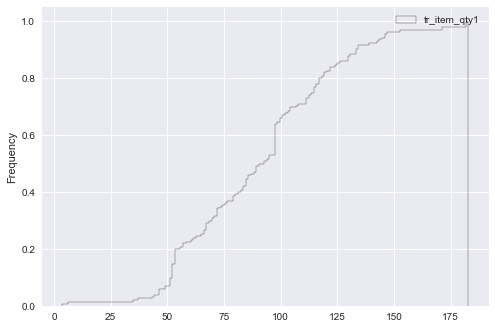

In [197]:
ft_bins = len(fuel_trans_df[ft_bs])
_ = fuel_trans_df[ft_bs].plot(kind='hist', x='tr_datetime', y='tr_item_qty1', color = 'k',
                              normed=True, cumulative = True, histtype = 'step', bins=ft_bins)
plt.scatter()
plt.show()

In [180]:
ft_cols = ['tr_id', 'tr_station_id', 'tr_station_name', 'tr_station_cty',
       'tr_station_st', 'tr_drvr_code', 'tr_unit_id', 'tr_item_cd1',
       'tr_item_qty1', 'tr_datetime']

fuel_trans_df[ft_bs][ft_cols]

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_datetime
495,42755127,231813,FJ-FORT PIERCE 622,FORT PIERCE,FL,WAGL,1534,ULSD,115.129997,2017-01-03 13:08:00
1962,43244834,516607,LOVES # 320 TRAVEL STOP,DUBLIN,GA,WAGL,1534,ULSD,144.929993,2017-01-07 08:57:00
2464,43418503,516641,LOVES # 360 TRAVEL STOP,HORSE CAVE,KY,WAGL,1534,ULSD,54.070000,2017-01-09 09:01:00
3205,43662675,516035,PILOT PORTERSVILLE NEW C,PORTERSVILLE,PA,WAGL,1534,ULSD,144.630005,2017-01-11 05:34:00
4026,43940637,516209,PILOT CAYCE (COLUMBIA ARE,CAYCE (COLUMBIA,SC,WAGL,1534,ULSD,124.680000,2017-01-13 05:43:00
4564,44121627,516234,PILOT BIRMINGHAM 369,BIRMINGHAM,AL,WAGL,1534,ULSD,147.550003,2017-01-14 18:14:00
5613,44480100,521834,PILOT JASPER 500,JASPER,FL,WAGL,1534,ULSD,182.199997,2017-01-18 06:06:00
7183,44985088,516641,LOVES # 360 TRAVEL STOP,HORSE CAVE,KY,WAGL,1534,ULSD,104.889999,2017-01-22 15:05:00
9170,45682275,516640,LOVES # 358 TRAVEL STOP,SHARTLESVILLE,PA,WAGL,1534,ULSD,182.839996,2017-01-27 17:25:00
9611,45853169,231100,FJ-BRUNSWICK 627,BRUNSWICK,GA,WAGL,1534,ULSD,54.110001,2017-01-29 15:24:00


In [164]:
#fuel_trans_df.tr_drvr_code = fuel_trans_df.tr_drvr_code.cat.remove_unused_categories()
#fuel_trans_df.tr_unit_id = fuel_trans_df.tr_unit_id.cat.remove_unused_categories()
#ft_dt_grp = fuel_trans_df[['tr_unit_id', 'tr_drvr_code', 'tr_id', 'tr_datetime']].groupby(['tr_unit_id', 'tr_drvr_code'])
ft_dt_grp.agg('size').to_frame('rows')#.sort_values('rows', ascending=False)

rows
tr_unit_id tr_drvr_code      
           1355             1
           1974             1
           4051             1
           6039             1
           8660             1
           9781             1
           ARCM             1
           COKJ             1
           HILB             2
           JOHA             3
           OPS              3
           PAGR             5
           SMIFR           15
           WHICH            1
1513       BAIJO            1
1520       MARMIS          23
1521       LOUR            38
1522       UHLS            29
1523       HEVD            25
           JORW             1
1524       DAVKE           35
1525       EDMJ             7
1526       ANDANT           1
           TANDA           15
1527       CROMA           43
1528       STEMI           41
1529       DAVKE            2
           HIAK            22
           NORJI            3
1530       ELLTH            5
...                       ...
2153       MALBO           14
2154       ROWP             7
2155       EVAJO            6
2156       WRIJON          10
243        PERT             4
           SIMR            46
245        LOVH             6
246        NEWR             1
301        DELST           13
           FERDE            9
           MOODO           29
302        EDEM            60
303        PATWE           42
           SMIFR           67
304        WILT01         247
305        LEAB            61
306        HALRAY          81
307        ARCM           297
308        ANTR            12
           CRAC           295
           STAH             1
309        GRIA             1
           SIMR            30
           WESD           117
310        BEVL            23
           PERT           100
5555       JONS            24
7777                       11
9927       1973             4
OFFICE     SPED            48

[1798 rows x 1 columns]

In [94]:
fuel_trans_grouped.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 104055 entries, (, 2017-02-20 18:00:00) to (ZAMJ, 2017-06-01 08:14:00)
Data columns (total 8 columns):
tr_id               104055 non-null category
tr_item_sum         104055 non-null float32
tr_count            104055 non-null int64
tr_drvr_id          104055 non-null category
tr_datetime         104055 non-null datetime64[ns]
next_tr_datetime    104054 non-null datetime64[ns]
next_tr_id          104054 non-null category
next_tr_item_sum    104054 non-null float32
dtypes: category(3), datetime64[ns](2), float32(2), int64(1)
memory usage: 28.6 MB


#### Events grouped by Driver and Truck

In [26]:
dt_grouped = events_levels_df.groupby(['DriverID', 'EquipmentID'])

#### Sizes of groups as a dataframe

In [27]:
dt_sizes = dt_grouped.size().to_frame('events').sort_values('events', ascending=False)

In [28]:
dt_sizes.loc['CRAMI']

,events
EquipmentID,
1795,4775
1598,56
1799,37


In [29]:
dt_sizes.shape

(2151, 1)

In [30]:
dt_sizes[dt_sizes.events < 20].shape[0]

340

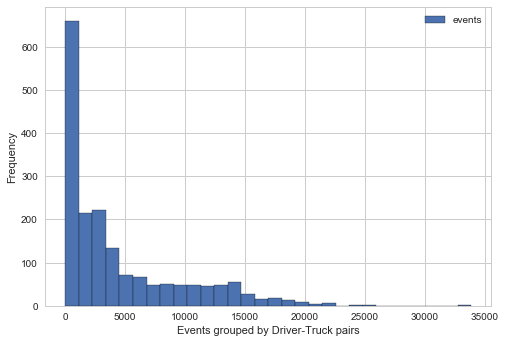

In [31]:
sns.set_style('whitegrid')
plt.rcParams["patch.force_edgecolor"] = True
dt_sizes[dt_sizes.events > 20].plot(kind='hist', bins=30)
plt.xlabel('Events grouped by Driver-Truck pairs')
plt.show()

In [32]:
dt_sizes.head(50).sort_index()

,,events
DriverID,EquipmentID,
ADAR,1950,18387
ANTR,1721,20956
ARCM,307,18415
BALD,1991,19249
BINA,1961,17271
BROD03,1941,22014
BUFB,1799,18922
BULR,1639,17809
BYRCHR,1734,18425


### Add columns to be populated with fuel transaction data

In [100]:
events_levels_df['refuel_datetime'] = np.NaN
events_levels_df.loc[:,['refuel_datetime']] = pd.to_datetime(events_levels_df['refuel_datetime'])

events_levels_df['refuel_tr_sum'] = np.NaN
events_levels_df.loc[:,['refuel_tr_sum']] = events_levels_df['refuel_tr_sum'].astype('float32')

events_levels_df['refuel_tr_id'] = '0'
events_levels_df.loc[:,'refuel_tr_id'] = events_levels_df.refuel_tr_id.astype(
    'category').cat.set_categories(
    # Set categories from fuel_trans_grouped.tr_id
    fuel_trans_grouped.tr_id.cat.categories).cat.as_ordered()

In [106]:
bs_abbv = fuel_trans_df.tr_drvr_code.isin(['ABBV'])
fuel_trans_df[bs_abbv].sort_values('tr_id').head()

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
29964,53074887,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,ABBV,1821,ULSD,91.660004,,0.0,,0.0,,0.0,,0.0,,0.0,2017-03-29 12:32:00
30501,53262743,516032,PILOT TUSCALOOSA 076,TUSCALOOSA,AL,ABBV,1821,ULSD,106.059998,,0.0,,0.0,,0.0,,0.0,,0.0,2017-03-30 16:51:00
30962,53458188,231039,FJ-BESSEMER 601,MCCALLA,AL,ABBV,1821,ULSD,50.840000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-04-01 08:27:00
31039,53480705,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,ABBV,1821,ULSD,91.970001,,0.0,,0.0,,0.0,,0.0,,0.0,2017-04-01 12:28:00
31285,53575090,231868,FJ-NEW CANEY 734,NEW CANEY,TX,ABBV,1821,ULSD,97.889999,,0.0,,0.0,,0.0,,0.0,,0.0,2017-04-02 14:43:00


In [178]:
events_levels_df = events_levels_df.set_index(
    ['DriverID', 'EventTimeStamp'], drop=False).sort_index(level=[0,1])

In [218]:
events_levels_df.IgnitionStatus.cat.set_categories

Index(['1', '2'], dtype='object')

In [222]:
el_test_df.head()

Id          EventTimeStamp  \
DriverID EventTimeStamp                                              
EDWTI    2017-01-01 03:04:30.430  12649371 2017-01-01 03:04:30.430   
         2017-01-01 03:05:10.447  12649373 2017-01-01 03:05:10.447   
         2017-01-01 03:12:40.493  12649378 2017-01-01 03:12:40.493   
         2017-01-01 03:55:30.697  12649422 2017-01-01 03:55:30.697   
         2017-01-01 03:55:30.697  12649452 2017-01-01 03:55:30.697   

                                 EquipmentID DriverID  Latitude  Longitude  \
DriverID EventTimeStamp                                                      
EDWTI    2017-01-01 03:04:30.430        1859    EDWTI  35.62109  -84.48851   
         2017-01-01 03:05:10.447        1859    EDWTI  35.62109  -84.48848   
         2017-01-01 03:12:40.493        1859    EDWTI  35.61801  -84.49756   
         2017-01-01 03:55:30.697        1859    EDWTI  35.15257  -84.94836   
         2017-01-01 03:55:30.697        1859    EDWTI  35.15257  -84.94836   

                                   LocationTimeStamp  Speed  Odometer  \
DriverID EventTimeStamp                                                 
EDWTI    2017-01-01 03:04:30.430 2017-01-01 03:04:29      0  108646.8   
         2017-01-01 03:05:10.447 2017-01-01 03:05:09      0  108646.8   
         2017-01-01 03:12:40.493 2017-01-01 03:12:38     47  108647.6   
         2017-01-01 03:55:30.697 2017-01-01 03:55:28      0  108689.5   
         2017-01-01 03:55:30.697 2017-01-01 03:55:28      0  108689.5   

                                 IgnitionStatus EFReportReason  \
DriverID EventTimeStamp                                          
EDWTI    2017-01-01 03:04:30.430              2              0   
         2017-01-01 03:05:10.447              2              1   
         2017-01-01 03:12:40.493              1              0   
         2017-01-01 03:55:30.697              1              2   
         2017-01-01 03:55:30.697              1              2   

                                  TankLevelPercent  TankLevelGallons  \
DriverID EventTimeStamp                                                
EDWTI    2017-01-01 03:04:30.430         73.599998        147.199997   
         2017-01-01 03:05:10.447         73.599998        147.199997   
         2017-01-01 03:12:40.493         69.400002        138.800003   
         2017-01-01 03:55:30.697         60.200001        120.400002   
         2017-01-01 03:55:30.697         60.200001        120.400002   

                                  ExactFuelEventId truck  tankcap  \
DriverID EventTimeStamp                                             
EDWTI    2017-01-01 03:04:30.430          12649371  1859      200   
         2017-01-01 03:05:10.447          12649373  1859      200   
         2017-01-01 03:12:40.493          12649378  1859      200   
         2017-01-01 03:55:30.697          12649422  1859      200   
         2017-01-01 03:55:30.697          12649452  1859      200   

                                     refuel_datetime  refuel_tr_sum  \
DriverID EventTimeStamp                                               
EDWTI    2017-01-01 03:04:30.430 2017-01-02 03:44:00          108.0   
         2017-01-01 03:05:10.447 2017-01-02 03:44:00          108.0   
         2017-01-01 03:12:40.493 2017-01-02 03:44:00          108.0   
         2017-01-01 03:55:30.697 2017-01-02 03:44:00          108.0   
         2017-01-01 03:55:30.697 2017-01-02 03:44:00          108.0   

                                 refuel_tr_id  
DriverID EventTimeStamp                        
EDWTI    2017-01-01 03:04:30.430     42629908  
         2017-01-01 03:05:10.447     42629908  
         2017-01-01 03:12:40.493     42629908  
         2017-01-01 03:55:30.697     42629908  
         2017-01-01 03:55:30.697     42629908

In [223]:
flags = flag_anomal_odom_rows_3(el_test_df)

In [225]:
events_levels_df.head()

Id          EventTimeStamp  \
DriverID EventTimeStamp                                              
NaN      2017-01-01 00:19:45.357  12649676 2017-01-01 00:19:45.357   
         2017-01-01 00:34:45.370  12649677 2017-01-01 00:34:45.370   
         2017-01-01 00:49:45.417  12649678 2017-01-01 00:49:45.417   
         2017-01-01 01:04:45.463  12649679 2017-01-01 01:04:45.463   
         2017-01-01 01:19:45.480  12649680 2017-01-01 01:19:45.480   

                                 EquipmentID DriverID  Latitude  Longitude  \
DriverID EventTimeStamp                                                      
NaN      2017-01-01 00:19:45.357        1559      NaN  36.06712  -86.43476   
         2017-01-01 00:34:45.370        1559      NaN  36.06712  -86.43476   
         2017-01-01 00:49:45.417        1559      NaN  36.06712  -86.43476   
         2017-01-01 01:04:45.463        1559      NaN  36.06712  -86.43476   
         2017-01-01 01:19:45.480        1559      NaN  36.06712  -86.43476   

                                   LocationTimeStamp  Speed  Odometer  \
DriverID EventTimeStamp                                                 
NaN      2017-01-01 00:19:45.357 2017-01-01 00:01:05      0  505629.3   
         2017-01-01 00:34:45.370 2017-01-01 00:01:05      0  505629.3   
         2017-01-01 00:49:45.417 2017-01-01 00:01:05      0  505629.3   
         2017-01-01 01:04:45.463 2017-01-01 00:01:05      0  505629.3   
         2017-01-01 01:19:45.480 2017-01-01 00:01:05      0  505629.3   

                                 IgnitionStatus EFReportReason  \
DriverID EventTimeStamp                                          
NaN      2017-01-01 00:19:45.357              1              2   
         2017-01-01 00:34:45.370              1              2   
         2017-01-01 00:49:45.417              1              2   
         2017-01-01 01:04:45.463              1              2   
         2017-01-01 01:19:45.480              1              2   

                                  TankLevelPercent  TankLevelGallons  \
DriverID EventTimeStamp                                                
NaN      2017-01-01 00:19:45.357              96.0             240.0   
         2017-01-01 00:34:45.370              96.0             240.0   
         2017-01-01 00:49:45.417              96.0             240.0   
         2017-01-01 01:04:45.463              96.0             240.0   
         2017-01-01 01:19:45.480              96.0             240.0   

                                  ExactFuelEventId truck  tankcap  \
DriverID EventTimeStamp                                             
NaN      2017-01-01 00:19:45.357          12649676  1559      250   
         2017-01-01 00:34:45.370          12649677  1559      250   
         2017-01-01 00:49:45.417          12649678  1559      250   
         2017-01-01 01:04:45.463          12649679  1559      250   
         2017-01-01 01:19:45.480          12649680  1559      250   

                                 refuel_datetime  refuel_tr_sum refuel_tr_id  
DriverID EventTimeStamp                                                       
NaN      2017-01-01 00:19:45.357             NaT            NaN          NaN  
         2017-01-01 00:34:45.370             NaT            NaN          NaN  
         2017-01-01 00:49:45.417             NaT            NaN          NaN  
         2017-01-01 01:04:45.463             NaT            NaN          NaN  
         2017-01-01 01:19:45.480             NaT            NaN          NaN

In [180]:
el_drivers = events_levels_df.index.get_level_values(level=0).unique().values-`1`

[NaN, 36728, ABBV, ACHC, ADADE, ..., YANH, YOUJE, YOURO, YOUW01, ZAMJ]
Length: 925
Categories (924, object): [36728, ABBV, ACHC, ADADE, ..., YOUJE, YOURO, YOUW01, ZAMJ]

In [187]:
ft_drivers = fuel_trans_grouped.index.get_level_values(level=0).unique().values
ft_drivers

[, 1355, 1973, 1974, 3068, ..., YANH, YOUJE, YOURO, YOUW01, ZAMJ]
Length: 937
Categories (937, object): [, 1355, 1973, 1974, ..., YOUJE, YOURO, YOUW01, ZAMJ]

In [190]:
shared_drivers = [driver for driver in el_drivers if driver in ft_drivers]
shared_trucks = [x for x in el_drivers if driver in ft_drivers]

In [ ]:
def update_fuel_trans_data(events_df, fuel_df, driver_list=shared_drivers):
    for driver in driver_list:
        driver_fuel_trans_df = fuel_df.loc[driver]
        #dft_test = fuel_trans_grouped.loc[driver]

        # Create event keys for re-indexing
        event_keys = events_levels_df.loc[driver,['EquipmentID', 'DriverID', 'EventTimeStamp']].copy().drop_duplicates().sort_index()

        # EventTimeStamp keys with transaction info for specific driver
        event_trans_keys = driver_fuel_trans_df.reindex(
            event_keys.index, method = 'nearest').sort_index()
        # [['tr_datetime', 'next_tr_datetime', 'tr_drvr_code', 'tr_unit_id']]

        # Add EventTimeStamp to columns
        event_trans_keys['EventTimeStamp'] = event_trans_keys.index.values

        # Boolean series identifying events that come after the nearest transaction
        es_gt_ts =  event_trans_keys.EventTimeStamp > event_trans_keys.tr_datetime

        # Add refuel_datetime
        event_trans_keys['refuel_datetime'] = np.where(es_gt_ts, 
                                                       event_trans_keys.next_tr_datetime, 
                                                       event_trans_keys.tr_datetime)
        # Add refuel_amount 
        event_trans_keys['refuel_tr_sum'] = np.where(es_gt_ts, 
                                                     event_trans_keys.next_tr_item_sum, 
                                                     event_trans_keys.tr_item_sum)

        # Add refuel_tr_id. Use two steps to keep categories
        event_trans_keys['refuel_tr_id'] = event_trans_keys['tr_id']
        event_trans_keys.loc[es_gt_ts,['refuel_tr_id']] = event_trans_keys['next_tr_id']

        # Columns to be added to events_levels_df 
        keep_cols = ['refuel_datetime', 'refuel_tr_sum', 'refuel_tr_id']

        # Update events_levels_df transaction columns for driver
        events_levels_df.loc[driver].update(event_trans_keys.loc[:, keep_cols])
        # Category dtype needs to be updated in separate step, apparently
        events_levels_df.loc[driver, 'refuel_tr_id'].update(event_trans_keys.loc[:, 'refuel_tr_id'])

In [101]:
events_levels_df[events_levels_df.refuel_tr_id.isnull()]['DriverID'].value_counts()

DYET          33866
SIMJIM        27161
VAUJAM        25712
ULAL          25449
ECKS          24105
CHAJO         23888
BULR          22974
BROD03        22253
CUNW          22195
PERT          21992
STEGA         21950
NARJ          21551
GALJU         21513
CHRN          21337
ANTR          20995
SWEJ          20839
FARMI         20808
TAYJON        20780
EDWTI         20767
SAVE          20310
DINE          20227
MORJAM        20193
CRES          19952
RUTP          19832
PRUH          19723
MARWI         19672
DEPK          19665
SIMJE         19398
SUTD          19355
WIET          19267
              ...  
36728             1
DAVKEN            1
KUNDAV            1
FURLA             1
BEAT              1
TAYDO1            1
RYAC              0
DUNG              0
BRAMAT            0
EDNJ              0
OWEJE             0
SHOP!             0
WORJON            0
BIVD              0
HARJI             0
KANR              0
NESD              0
JOHLO             0
CUMR              0


In [201]:
# Index over which to loop
#el_drivers = el_drivers[el_drivers.isnull() == False]
#sample_trucks = ['2014']
#el_test_df.loc[driver]
# Temp df based on DriverID
for driver in shared_drivers[20:]:
    driver_fuel_trans_df = fuel_trans_grouped.loc[driver]
    #dft_test = fuel_trans_grouped.loc[driver]

    # Create event keys for re-indexing
    event_keys = events_levels_df.loc[driver,['EquipmentID', 'DriverID', 'EventTimeStamp']].drop_duplicates().sort_index()

    # EventTimeStamp keys with transaction info for specific driver
    event_trans_keys = driver_fuel_trans_df.reindex(
        event_keys.index, method = 'nearest').sort_index()
    # [['tr_datetime', 'next_tr_datetime', 'tr_drvr_code', 'tr_unit_id']]

    # Add EventTimeStamp to columns
    event_trans_keys['EventTimeStamp'] = event_trans_keys.index.values

    # Boolean series identifying events that come after the nearest transaction
    es_gt_ts =  event_trans_keys.EventTimeStamp > event_trans_keys.tr_datetime

    # Add refuel_datetime
    event_trans_keys['refuel_datetime'] = np.where(es_gt_ts, 
                                                   event_trans_keys.next_tr_datetime, 
                                                   event_trans_keys.tr_datetime)
    # Add refuel_amount 
    event_trans_keys['refuel_tr_sum'] = np.where(es_gt_ts, 
                                                 event_trans_keys.next_tr_item_sum, 
                                                 event_trans_keys.tr_item_sum)

    # Add refuel_tr_id. Use two steps to keep categories
    event_trans_keys['refuel_tr_id'] = event_trans_keys['tr_id']
    event_trans_keys.loc[es_gt_ts,['refuel_tr_id']] = event_trans_keys['next_tr_id']

    # Columns to be added to events_levels_df 
    keep_cols = ['refuel_datetime', 'refuel_tr_sum', 'refuel_tr_id']
    
    # Update events_levels_df transaction columns for driver
    events_levels_df.loc[driver].update(event_trans_keys.loc[:, keep_cols])
    # Category dtype needs to be updated in separate step, apparently
    events_levels_df.loc[driver, 'refuel_tr_id'].update(event_trans_keys.loc[:, 'refuel_tr_id'])
#events_levels_df.loc[sample_drivers[0]].head()
#events_levels_df.loc[sample_drivers[1]].head()

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3863: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raise_on_error=True)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


ValueError: NumPy boolean array indexing assignment cannot assign 3920 input values to the 3831 output values where the mask is true

In [202]:
 events_levels_df.isnull()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7908406 entries, (nan, 2017-01-01 00:19:45.357000) to (ZAMJ, 2017-06-02 20:03:56.623000)
Data columns (total 19 columns):
Id                   uint64
EventTimeStamp       datetime64[ns]
EquipmentID          category
DriverID             category
Latitude             float64
Longitude            float64
LocationTimeStamp    datetime64[ns]
Speed                uint16
Odometer             float64
IgnitionStatus       category
EFReportReason       category
TankLevelPercent     float32
TankLevelGallons     float32
ExactFuelEventId     uint64
truck                category
tankcap              uint16
refuel_datetime      datetime64[ns]
refuel_tr_sum        float32
refuel_tr_id         category
dtypes: category(6), datetime64[ns](3), float32(3), float64(3), uint16(2), uint64(2)
memory usage: 810.1 MB


### Sample data for specific drivers

In [200]:
events_levels_df.loc[shared_drivers[12]].head()

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,refuel_datetime,refuel_tr_sum,refuel_tr_id
EventTimeStamp,,,,,,,,,,,,,,,,,,,
2017-01-24 15:19:32.643,13076485,2017-01-24 15:19:32.643,1619,AMMC,36.06727,-86.43356,2017-01-24 15:19:35,0,488433.1,1,0,100.000000,230.000000,13076485,1619,230,2017-01-27 16:25:00,168.149994,45675224
2017-01-24 15:34:32.707,13076779,2017-01-24 15:34:32.707,1619,AMMC,36.06744,-86.43444,2017-01-24 15:34:35,0,488433.4,1,2,100.000000,230.000000,13076779,1619,230,2017-01-27 16:25:00,168.149994,45675224
2017-01-24 15:49:32.830,13077096,2017-01-24 15:49:32.830,1619,AMMC,36.03936,-86.42895,2017-01-24 15:49:35,65,488443.5,1,2,99.699997,229.309998,13077096,1619,230,2017-01-27 16:25:00,168.149994,45675224
2017-01-24 15:57:32.893,13077278,2017-01-24 15:57:32.893,1619,AMMC,36.06714,-86.43484,2017-01-24 15:57:35,0,488446.2,2,1,100.000000,230.000000,13077278,1619,230,2017-01-27 16:25:00,168.149994,45675224
2017-01-24 15:59:22.893,13077312,2017-01-24 15:59:22.893,1619,AMMC,36.06715,-86.43484,2017-01-24 15:59:25,0,488446.2,2,0,100.000000,230.000000,13077312,1619,230,2017-01-27 16:25:00,168.149994,45675224


In [33]:
fuel_trans_grouped.head()

tr_id  tr_item_sum  tr_count tr_drvr_id  \
tr_drvr_code tr_datetime                                                       
             2017-02-20 18:00:00  48522317   115.120003         1              
             2017-03-07 08:37:00  50291739   139.919998         1              
             2017-03-10 09:33:00  50737460   131.149994         1              
             2017-03-12 00:26:00  50921680    86.209999         1              
             2017-03-16 19:20:00  51539672    60.189999         1              

                                         tr_datetime    next_tr_datetime  \
tr_drvr_code tr_datetime                                                   
             2017-02-20 18:00:00 2017-02-20 18:00:00 2017-03-07 08:37:00   
             2017-03-07 08:37:00 2017-03-07 08:37:00 2017-03-10 09:33:00   
             2017-03-10 09:33:00 2017-03-10 09:33:00 2017-03-12 00:26:00   
             2017-03-12 00:26:00 2017-03-12 00:26:00 2017-03-16 19:20:00   
             2017-03-16 19:20:00 2017-03-16 19:20:00 2017-03-28 07:28:00   

                                 next_tr_id  next_tr_item_sum  
tr_drvr_code tr_datetime                                       
             2017-02-20 18:00:00   50291739        139.919998  
             2017-03-07 08:37:00   50737460        131.149994  
             2017-03-10 09:33:00   50921680         86.209999  
             2017-03-12 00:26:00   51539672         60.189999  
             2017-03-16 19:20:00   52889525        135.020004

In [161]:
# Test df indexed by DriverID and EventTimeStamp, with two driver IDs
el_test_df = events_levels_df[events_levels_df.DriverID.isin(['SAVE', 'EDWTI'])].set_index(
['DriverID', 'EventTimeStamp'], drop=False).sort_index(level=[0,1])
df_len = el_test_df.shape[0]

el_test_df['refuel_datetime'] = np.NaN
el_test_df.loc[:,['refuel_datetime']] = pd.to_datetime(el_test_df['refuel_datetime'])

el_test_df['refuel_tr_sum'] = np.NaN
el_test_df.loc[:,['refuel_tr_sum']] = el_test_df['refuel_tr_sum'].astype('float32')


el_test_df['refuel_tr_id'] = '0'
el_test_df.loc[:,'refuel_tr_id'] = el_test_df.refuel_tr_id.astype(
    'category').cat.set_categories(
    # Set categories from fuel_trans_grouped.tr_id
    fuel_trans_grouped.tr_id.cat.categories).cat.as_ordered()

el_test_df.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 41077 entries, (EDWTI, 2017-01-01 03:04:30.430000) to (SAVE, 2018-03-23 08:09:50.607000)
Data columns (total 19 columns):
Id                   41077 non-null uint64
EventTimeStamp       41077 non-null datetime64[ns]
EquipmentID          41077 non-null category
DriverID             41077 non-null category
Latitude             41077 non-null float64
Longitude            41077 non-null float64
LocationTimeStamp    41077 non-null datetime64[ns]
Speed                41077 non-null uint16
Odometer             41077 non-null float64
IgnitionStatus       41077 non-null category
EFReportReason       41077 non-null category
TankLevelPercent     41077 non-null float32
TankLevelGallons     41077 non-null float32
ExactFuelEventId     41077 non-null uint64
truck                41077 non-null category
tankcap              41077 non-null uint16
refuel_datetime      0 non-null datetime64[ns]
refuel_tr_sum        0 non-null float32
refuel_tr_id         0

In [162]:
# Test df refuel_tr_id column has correct categories
el_test_df.refuel_tr_id.cat.categories

Index(['1000077', '1000433', '1001871', '1002438', '1002835', '1003597',
       '1004402', '1004525', '1004652', '100496',
       ...
       '99990201', '99992055', '99992769', '99993207', '99996963', '99997440',
       '99997584', '99997884', '99998205', '99998578'],
      dtype='object', length=104055)

In [166]:
# Index over which to loop
sample_drivers = el_test_df.index.get_level_values(level=0).unique().values
sample_drivers = el_test_df.index.get_level_values(level=0).unique().values
#sample_trucks = ['2014']
#el_test_df.loc[driver]
# Temp df based on DriverID
for driver in sample_drivers:
    dft_test = fuel_trans_grouped.loc[driver]

    # Create event keys for re-indexing
    eks_test = el_test_df.loc[driver,['EquipmentID', 'DriverID', 'EventTimeStamp']].drop_duplicates().sort_index()

    # EventTimeStamp keys with transaction info for specific driver
    etks_test = dft_test.reindex(
        eks_test.index, method = 'nearest').sort_index()
    # [['tr_datetime', 'next_tr_datetime', 'tr_drvr_code', 'tr_unit_id']]

    # Add EventTimeStamp to columns
    etks_test['EventTimeStamp'] = etks_test.index.values

    # Boolean series identifying events that come after the nearest transaction
    es_gt_ts =  etks_test.EventTimeStamp > etks_test.tr_datetime

    # Add refuel_datetime
    etks_test['refuel_datetime'] = np.where(es_gt_ts, etks_test.next_tr_datetime, 
                                                          etks_test.tr_datetime)
    # Add refuel_amount 
    etks_test['refuel_tr_sum'] = np.where(es_gt_ts, etks_test.next_tr_item_sum, 
                                                          etks_test.tr_item_sum)

    # Add refuel_tr_id. Use two steps to keep categories
    etks_test['refuel_tr_id'] = etks_test['tr_id']
    etks_test.loc[es_gt_ts,['refuel_tr_id']] = etks_test['next_tr_id']

    # Columns to be added to events_levels_df 
    keep_cols = ['refuel_datetime', 'refuel_tr_sum', 'refuel_tr_id']


    el_test_df.loc[driver].update(etks_test.loc[:, keep_cols])
    # Category dtype needs to be updated in separate step, apparently
    el_test_df.loc[driver, 'refuel_tr_id'].update(etks_test.loc[:, 'refuel_tr_id'])
el_test_df.loc[sample_drivers[0]].head()
el_test_df.loc[sample_drivers[1]].head()

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3863: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raise_on_error=True)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,refuel_datetime,refuel_tr_sum,refuel_tr_id
EventTimeStamp,,,,,,,,,,,,,,,,,,,
2017-01-01 15:37:48.733,12652824,2017-01-01 15:37:48.733,1934,SAVE,35.66991,-84.09216,2017-01-01 15:37:47,0,91862.0,2,1,93.699997,187.399994,12652824,1934,200,2017-01-03 11:23:00,123.0,42742258
2017-01-01 15:38:08.703,12652826,2017-01-01 15:38:08.703,1934,SAVE,35.66992,-84.09215,2017-01-01 15:38:07,0,91862.0,2,0,93.699997,187.399994,12652826,1934,200,2017-01-03 11:23:00,123.0,42742258
2017-01-01 15:42:38.717,12652852,2017-01-01 15:42:38.717,1934,SAVE,35.66201,-84.10810,2017-01-01 15:42:37,56,91863.0,1,0,95.099998,190.199997,12652852,1934,200,2017-01-03 11:23:00,123.0,42742258
2017-01-01 15:57:38.797,12652914,2017-01-01 15:57:38.797,1934,SAVE,35.56196,-84.29763,2017-01-01 15:57:37,58,91875.9,1,2,91.199997,182.399994,12652914,1934,200,2017-01-03 11:23:00,123.0,42742258
2017-01-01 15:57:38.797,12652958,2017-01-01 15:57:38.797,1934,SAVE,35.56196,-84.29763,2017-01-01 15:57:37,58,91875.9,1,2,91.199997,182.399994,12652958,1934,200,2017-01-03 11:23:00,123.0,42742258


In [221]:
# lets try to optimize the performance of the flagging function

def flag_anomal_odom_rows_3(df, 
                            sort_col_1 = 'truck', 
                            sort_col_2 = 'EventTimeStamp'):#!!!! requires a dataframe with a reset index!!!!
    '''takes a dataframe with an Odometer column and returns a boolean index of 
    identifying which rows are noisy Odometer readings and should be dropped.
    It also sorts the df by two columns'''
    
    #sort the df by truck and EventTimeStamp
    df.sort_values([sort_col_1, sort_col_2], inplace = True)
    
    
    #initialize a series, without attaching it to the df in the hopes of expediency
    OdomDiff = df.Odometer.diff()
    
    #initialize list which will serve as a boolean index
    flags = []
    
    flag = 1 #this will be flipped like a switch 1 means do not drop, 0 means drop

    #loop through each difference measurement
    for i in range(len(OdomDiff) - 1):
    # the loop will flag all but the last row because otherwise I'd have to find a way to loop around the "corner" of the index
    #            
    #   #will start by flaggin with 1 (do not drop) until an anomaly flips it.
        flags.append(bool(flag))
    #    
    #   # for each truck, if odometer change is anomalous (i.e. spikes up or down) flip the flag switch
        if (df.truck[i + 1] == df.truck[i]) & (abs(OdomDiff[i + 1]) > 200): 
            flag = (flag + 1)%2
    #       #the flag will remain on the delete (i.e. 0) setting until the loop detects the spike that corrects the odometer
    #       
    #   # if we change trucks before the anomaly is corrected reset the flag to do not drop (i.e. 1)   
        if df.truck[i + 1] != df.truck[i]:
            flag = 1
    #        
    #now that the loop is done, we append the last flag (which is in the state the loop left it. So, if a loop ends before the anomaly is corrected, the flag will still be set at 0/False)
    flags.append(bool(flag))
    
    return flags

In [167]:
el_test_df.loc[sample_drivers[0]].head()

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,refuel_datetime,refuel_tr_sum,refuel_tr_id
EventTimeStamp,,,,,,,,,,,,,,,,,,,
2017-01-01 03:04:30.430,12649371,2017-01-01 03:04:30.430,1859,EDWTI,35.62109,-84.48851,2017-01-01 03:04:29,0,108646.8,2,0,73.599998,147.199997,12649371,1859,200,2017-01-02 03:44:00,108.0,42629908
2017-01-01 03:05:10.447,12649373,2017-01-01 03:05:10.447,1859,EDWTI,35.62109,-84.48848,2017-01-01 03:05:09,0,108646.8,2,1,73.599998,147.199997,12649373,1859,200,2017-01-02 03:44:00,108.0,42629908
2017-01-01 03:12:40.493,12649378,2017-01-01 03:12:40.493,1859,EDWTI,35.61801,-84.49756,2017-01-01 03:12:38,47,108647.6,1,0,69.400002,138.800003,12649378,1859,200,2017-01-02 03:44:00,108.0,42629908
2017-01-01 03:55:30.697,12649422,2017-01-01 03:55:30.697,1859,EDWTI,35.15257,-84.94836,2017-01-01 03:55:28,0,108689.5,1,2,60.200001,120.400002,12649422,1859,200,2017-01-02 03:44:00,108.0,42629908
2017-01-01 03:55:30.697,12649452,2017-01-01 03:55:30.697,1859,EDWTI,35.15257,-84.94836,2017-01-01 03:55:28,0,108689.5,1,2,60.200001,120.400002,12649452,1859,200,2017-01-02 03:44:00,108.0,42629908


In [154]:
el_test_df.loc['EDWTI'].update(etks_test.loc[:, keep_cols])
el_test_df.loc['EDWTI', 'refuel_tr_id'].update(etks_test.loc[:, 'refuel_tr_id'])
el_test_df.loc['EDWTI'].head()

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3863: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raise_on_error=True)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,refuel_datetime,refuel_tr_sum,refuel_tr_id
EventTimeStamp,,,,,,,,,,,,,,,,,,,
2017-01-01 03:04:30.430,12649371,2017-01-01 03:04:30.430,1859,EDWTI,35.62109,-84.48851,2017-01-01 03:04:29,0,108646.8,2,0,73.599998,147.199997,12649371,1859,200,2017-01-02 03:44:00,108.0,42629908
2017-01-01 03:05:10.447,12649373,2017-01-01 03:05:10.447,1859,EDWTI,35.62109,-84.48848,2017-01-01 03:05:09,0,108646.8,2,1,73.599998,147.199997,12649373,1859,200,2017-01-02 03:44:00,108.0,42629908
2017-01-01 03:12:40.493,12649378,2017-01-01 03:12:40.493,1859,EDWTI,35.61801,-84.49756,2017-01-01 03:12:38,47,108647.6,1,0,69.400002,138.800003,12649378,1859,200,2017-01-02 03:44:00,108.0,42629908
2017-01-01 03:55:30.697,12649422,2017-01-01 03:55:30.697,1859,EDWTI,35.15257,-84.94836,2017-01-01 03:55:28,0,108689.5,1,2,60.200001,120.400002,12649422,1859,200,2017-01-02 03:44:00,108.0,42629908
2017-01-01 03:55:30.697,12649452,2017-01-01 03:55:30.697,1859,EDWTI,35.15257,-84.94836,2017-01-01 03:55:28,0,108689.5,1,2,60.200001,120.400002,12649452,1859,200,2017-01-02 03:44:00,108.0,42629908


In [149]:
etks_test.tr_id.cat.codes[100:105]

EventTimeStamp
2017-01-02 14:19:46.640    2230
2017-01-02 14:59:56.797    2230
2017-01-02 15:05:26.827    2230
2017-01-02 15:07:16.843    2230
2017-01-02 15:09:16.843    2230
dtype: int32

In [148]:
etks_test.refuel_tr_id.cat.codes[100:105]

EventTimeStamp
2017-01-02 14:19:46.640    2469
2017-01-02 14:59:56.797    2469
2017-01-02 15:05:26.827    2469
2017-01-02 15:07:16.843    2469
2017-01-02 15:09:16.843    2469
dtype: int32

In [156]:
el_test_df.shape

(41077, 16)

In [161]:
el_test_df['refuel_tr_sum'] = np.NaN
el_test_df.loc[:,['refuel_tr_sum']] = el_test_df['refuel_tr_sum'].astype('float32')

In [163]:
el_test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 41077 entries, (EDWTI, 2017-01-01 03:04:30.430000) to (SAVE, 2018-03-23 08:09:50.607000)
Data columns (total 18 columns):
Id                   41077 non-null uint64
EventTimeStamp       41077 non-null datetime64[ns]
EquipmentID          41077 non-null category
DriverID             41077 non-null category
Latitude             41077 non-null float64
Longitude            41077 non-null float64
LocationTimeStamp    41077 non-null datetime64[ns]
Speed                41077 non-null uint16
Odometer             41077 non-null float64
IgnitionStatus       41077 non-null category
EFReportReason       41077 non-null category
TankLevelPercent     41077 non-null float32
TankLevelGallons     41077 non-null float32
ExactFuelEventId     41077 non-null uint64
truck                41077 non-null category
tankcap              41077 non-null uint16
refuel_datetime      0 non-null datetime64[ns]
refuel_tr_sum        0 non-null float32
dtypes: category(5), d

In [113]:
etks_test[keep_cols].head()
el_test_df.loc['EDWTI'].head()

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap
EventTimeStamp,,,,,,,,,,,,,,,,
2017-01-01 03:04:30.430,12649371,2017-01-01 03:04:30.430,1859,EDWTI,35.62109,-84.48851,2017-01-01 03:04:29,0,108646.8,2,0,73.599998,147.199997,12649371,1859,200
2017-01-01 03:05:10.447,12649373,2017-01-01 03:05:10.447,1859,EDWTI,35.62109,-84.48848,2017-01-01 03:05:09,0,108646.8,2,1,73.599998,147.199997,12649373,1859,200
2017-01-01 03:12:40.493,12649378,2017-01-01 03:12:40.493,1859,EDWTI,35.61801,-84.49756,2017-01-01 03:12:38,47,108647.6,1,0,69.400002,138.800003,12649378,1859,200
2017-01-01 03:55:30.697,12649422,2017-01-01 03:55:30.697,1859,EDWTI,35.15257,-84.94836,2017-01-01 03:55:28,0,108689.5,1,2,60.200001,120.400002,12649422,1859,200
2017-01-01 03:55:30.697,12649452,2017-01-01 03:55:30.697,1859,EDWTI,35.15257,-84.94836,2017-01-01 03:55:28,0,108689.5,1,2,60.200001,120.400002,12649452,1859,200


In [61]:
sample_drivers = ['EDWTI']
sample_trucks = ['2014']
events_col_list = ['EventTimeStamp', 'Odometer', 'TankLevelPercent', 'IgnitionStatus', 'EFReportReason',
                   'Speed',  'TankLevelGallons', 'Latitude', 'Longitude', 'LocationTimeStamp',
                  'tankcap', 'EquipmentID', 'DriverID']
#drivers_events = events_levels_df[sample_bool_series].loc[:, events_col_list].set_index(
#    'EventTimeStamp', drop=False).sort_index()
#drivers_event_trans_keys = drivers_fuel_trans[['tr_datetime', 'next_tr_datetime', 'tr_drvr_code', 'tr_unit_id']].reindex(
#    event_keys.index, method = 'nearest').sort_index()

#es_gt_ts =  drivers_event_trans_keys.EventTimeStamp > drivers_event_trans_keys.tr_datetime

#drivers_event_trans_keys['EventTimeStamp'] = drivers_event_trans_keys.index.values
#drivers_event_trans_keys['refuel_datetime'] = np.where(es_gt_ts, drivers_event_trans_keys.next_tr_datetime, 
#                                                      drivers_event_trans_keys.tr_datetime

event_keys = events_levels_df[['EquipmentID', 'DriverID', 'EventTimeStamp']].drop_duplicates().sort_index(level=[0,1,2])
#events_trans_df = fuel_trans_grouped.reindex(event_keys.index, method = 'nearest').sort_index()



In [230]:
bad_ids = pd.read_csv('bad_ids.csv', header=None, names=['Id']).Id.tolist()
keep_ids = events_levels_df.Id.isin(bad_ids) == False
keep_ids[:5]

DriverID  EventTimeStamp         
NaN       2017-01-01 00:19:45.357    True
          2017-01-01 00:34:45.370    True
          2017-01-01 00:49:45.417    True
          2017-01-01 01:04:45.463    True
          2017-01-01 01:19:45.480    True
Name: Id, dtype: bool

In [64]:
gc.collect()

66

In [ ]:
event_trans_keys['EventTimeStamp'] = fuel_trans_grouped.index.values
es_gt_ts =  event_trans_keys.EventTimeStamp > event_trans_keys.tr_datetime

event_trans_keys['EventTimeStamp'] = drivers_event_trans_keys.index.values
event_trans_keys['refuel_datetime'] = np.where(es_gt_ts, event_trans_keys.next_tr_datetime, 
                                                      event_trans_keys.tr_datetime)

In [87]:
sample_drivers = ['EDWTI']
sample_trucks = ['2014']
truck_driver_idx = sample_trucks + sample_drivers 

In [92]:
sample_drivers = ['EDWTI']
sample_trucks = ['2014']
truck_driver_idx = sample_trucks + sample_drivers 
events_col_list = ['EventTimeStamp', 'Odometer', 'TankLevelPercent', 'IgnitionStatus', 'EFReportReason',
                   'Speed',  'TankLevelGallons', 'Latitude', 'Longitude', 'LocationTimeStamp',
                  'tankcap', 'EquipmentID', 'DriverID']
#sample_bool_series = np.logical_and(events_levels_df.DriverID.isin(sample_drivers), 
#                                   events_levels_df.EquipmentID.isin(sample_trucks))
#drivers_events = events_levels_df[sample_bool_series].loc[:, events_col_list].set_index(
#    ['EquipmentID','EventTimeStamp'], drop=False).sort_index()

drivers_events = events_levels_df.loc[truck_driver_idx]

trans_col_list = ['tr_datetime', 'tr_id', 'tr_item_cd1', 'tr_item_qty1', 'tr_station_id', 
                  'tr_station_name','tr_station_cty', 'tr_station_st', 'tr_drvr_code', 'tr_unit_id'] 

# Filter to only specific driver and unit, set index to transaction time, then order index
#sample_tran_bool_series = np.logical_and(fuel_trans_grouped.tr_drvr_code.isin(sample_drivers), 
#                                   fuel_trans_grouped.tr_unit_id.isin(sample_trucks))

drivers_fuel_trans = fuel_trans_grouped.loc[truck_driver_idx]

#drivers_fuel_trans = fuel_trans_df[sample_tran_bool_series].loc[:, trans_col_list].set_index(
#    'tr_datetime', drop=False).sort_index()
# Add the next tr_datetime column
drivers_fuel_trans['next_tr_datetime'] = drivers_fuel_trans.tr_datetime.shift(-1)


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
pd.read_csv()

In [240]:
for dt, col in zip(events_levels_df.dtypes, events_levels_df.columns):
    print("'" + col + "' : '" + str(dt) + "', ")

'Id' : 'uint64', 
'EventTimeStamp' : 'datetime64[ns]', 
'EquipmentID' : 'category', 
'DriverID' : 'category', 
'Latitude' : 'float64', 
'Longitude' : 'float64', 
'LocationTimeStamp' : 'datetime64[ns]', 
'Speed' : 'uint16', 
'Odometer' : 'float64', 
'IgnitionStatus' : 'category', 
'EFReportReason' : 'category', 
'TankLevelPercent' : 'float32', 
'TankLevelGallons' : 'float32', 
'ExactFuelEventId' : 'uint64', 
'truck' : 'category', 
'tankcap' : 'uint16', 
'refuel_datetime' : 'datetime64[ns]', 
'refuel_tr_sum' : 'float32', 
'refuel_tr_id' : 'category', 


In [ ]:
dtype_dict = {
    'Id' : 'uint64', 
    'EventTimeStamp' : 'datetime64', 
    'EquipmentID' : 'category', 
    'DriverID' : 'category', 
    'Latitude' : 'float64', 
    'Longitude' : 'float64', 
    'LocationTimeStamp' : 'datetime64', 
    'Speed' : 'uint16', 
    'Odometer' : 'float64', 
    'IgnitionStatus' : 'category', 
    'EFReportReason' : 'category', 
    'TankLevelPercent' : 'float32', 
    'TankLevelGallons' : 'float32', 
    'ExactFuelEventId' : 'uint64', 
    'truck' : 'category', 
    'tankcap' : 'uint16', 
    'refuel_datetime' : 'datetime64', 
    'refuel_tr_sum' : 'float32', 
    'refuel_tr_id' : 'category' }
date_cols = ['EventTimeStamp', 'LocationTimeStamp', 'refuel_datetime' ]

In [93]:
drivers_fuel_trans.head()

tr_id  tr_item_sum  tr_count  \
tr_unit_id tr_drvr_code tr_datetime                                            
2014       EDWTI        2017-01-12 06:10:00  43803629   138.000000         1   
                        2017-01-13 10:55:00  43974249   102.000000         1   
                        2017-01-15 10:03:00  44158298   125.000000         1   
                        2017-01-18 08:07:00  44491075   142.000000         1   
                        2017-01-20 04:19:00  44743103   130.009995         1   

                                            tr_unit_id tr_drvr_id  \
tr_unit_id tr_drvr_code tr_datetime                                 
2014       EDWTI        2017-01-12 06:10:00       2014      EDWTI   
                        2017-01-13 10:55:00       2014      EDWTI   
                        2017-01-15 10:03:00       2014      EDWTI   
                        2017-01-18 08:07:00       2014      EDWTI   
                        2017-01-20 04:19:00       2014      EDWTI   

                                                    tr_datetime  \
tr_unit_id tr_drvr_code tr_datetime                               
2014       EDWTI        2017-01-12 06:10:00 2017-01-12 06:10:00   
                        2017-01-13 10:55:00 2017-01-13 10:55:00   
                        2017-01-15 10:03:00 2017-01-15 10:03:00   
                        2017-01-18 08:07:00 2017-01-18 08:07:00   
                        2017-01-20 04:19:00 2017-01-20 04:19:00   

                                               next_tr_datetime  
tr_unit_id tr_drvr_code tr_datetime                              
2014       EDWTI        2017-01-12 06:10:00 2017-01-13 10:55:00  
                        2017-01-13 10:55:00 2017-01-15 10:03:00  
                        2017-01-15 10:03:00 2017-01-18 08:07:00  
                        2017-01-18 08:07:00 2017-01-20 04:19:00  
                        2017-01-20 04:19:00 2017-01-21 07:54:00

In [ ]:
#drivers_events.loc['2017-01-12 05:56': '2017-01-12 12:15']

In [63]:
drivers_events = events_levels_df[sample_bool_series].loc[:, events_col_list].set_index(
    ['EquipmentID','EventTimeStamp'], drop=False).sort_index()
drivers_fuel_trans = fuel_trans_grouped.loc[sample_trucks]
drivers_fuel_trans.head()

tr_id  tr_item_sum  tr_count  \
tr_unit_id tr_datetime                                            
2014       2017-01-12 06:10:00  43803629   138.000000         1   
           2017-01-13 10:55:00  43974249   102.000000         1   
           2017-01-15 10:03:00  44158298   125.000000         1   
           2017-01-18 08:07:00  44491075   142.000000         1   
           2017-01-20 04:19:00  44743103   130.009995         1   

                                       tr_datetime  
tr_unit_id tr_datetime                              
2014       2017-01-12 06:10:00 2017-01-12 06:10:00  
           2017-01-13 10:55:00 2017-01-13 10:55:00  
           2017-01-15 10:03:00 2017-01-15 10:03:00  
           2017-01-18 08:07:00 2017-01-18 08:07:00  
           2017-01-20 04:19:00 2017-01-20 04:19:00

In [35]:
fuel_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104056 entries, 1 to 147860
Data columns (total 20 columns):
tr_id              104056 non-null uint32
tr_station_id      104056 non-null category
tr_station_name    104056 non-null category
tr_station_cty     104056 non-null category
tr_station_st      104056 non-null category
tr_drvr_code       104056 non-null category
tr_unit_id         104056 non-null category
tr_item_cd1        104056 non-null category
tr_item_qty1       104056 non-null float32
tr_item_cd2        104056 non-null category
tr_item_qty2       104056 non-null float32
tr_item_cd3        104056 non-null category
tr_item_qty3       104056 non-null float32
tr_item_cd4        104056 non-null category
tr_item_qty4       104056 non-null float32
tr_item_cd5        104056 non-null category
tr_item_qty5       104056 non-null float32
tr_item_cd6        104056 non-null category
tr_item_qty6       104056 non-null float32
tr_datetime        104056 non-null datetime64[ns]
dtypes: cat

In [43]:

trans_col_list = ['tr_datetime', 'tr_id', 'tr_item_cd1', 'tr_item_qty1', 'tr_station_id', 
                  'tr_station_name','tr_station_cty', 'tr_station_st', 'tr_drvr_code', 'tr_unit_id'] 

# Filter to only specific driver and unit, set index to transaction time, then order index
sample_tran_bool_series = np.logical_and(fuel_trans_df.tr_drvr_code.isin(sample_drivers), 
                                   fuel_trans_df.tr_unit_id.isin(sample_trucks))
drivers_fuel_trans = fuel_trans_df[sample_tran_bool_series].loc[:, trans_col_list].set_index(
    'tr_datetime', drop=False).sort_index()
# Add the next tr_datetime column
drivers_fuel_trans['next_tr_datetime'] = drivers_fuel_trans.tr_datetime.shift(-1)

event_keys = drivers_events[['EventTimeStamp','EquipmentID', 'DriverID']].drop_duplicates()
drivers_event_trans_keys = drivers_fuel_trans[['tr_datetime', 'next_tr_datetime', 'tr_drvr_code', 'tr_unit_id']].reindex(
    event_keys.index, method = 'nearest').sort_index()
drivers_event_trans_keys['EventTimeStamp'] = drivers_event_trans_keys.index.values

In [44]:
drivers_fuel_trans[:4]

,tr_datetime,tr_id,tr_item_cd1,tr_item_qty1,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,next_tr_datetime
tr_datetime,,,,,,,,,,,
2017-01-12 06:10:00,2017-01-12 06:10:00,43803629,ULSD,138.0,231060,FJ-CARLISLE 708,CARLISLE,PA,EDWTI,2014,2017-01-13 10:55:00
2017-01-13 10:55:00,2017-01-13 10:55:00,43974249,ULSD,102.0,231846,FJ-MAX MEADOWS 750,FORT CHISWELL,VA,EDWTI,2014,2017-01-15 10:03:00
2017-01-15 10:03:00,2017-01-15 10:03:00,44158298,ULSD,125.0,515984,PILOT SEVILLE 013,SEVILLE,OH,EDWTI,2014,2017-01-18 08:07:00
2017-01-18 08:07:00,2017-01-18 08:07:00,44491075,ULSD,142.0,516271,PILOT WHITE PINE 412,WHITE PINE,TN,EDWTI,2014,2017-01-20 04:19:00


In [45]:
print(drivers_fuel_trans.tr_datetime[1])
print(drivers_fuel_trans.tr_datetime[0])
print(drivers_fuel_trans.head())

2017-01-13 10:55:00
2017-01-12 06:10:00
                            tr_datetime     tr_id tr_item_cd1  tr_item_qty1  \
tr_datetime                                                                   
2017-01-12 06:10:00 2017-01-12 06:10:00  43803629        ULSD    138.000000   
2017-01-13 10:55:00 2017-01-13 10:55:00  43974249        ULSD    102.000000   
2017-01-15 10:03:00 2017-01-15 10:03:00  44158298        ULSD    125.000000   
2017-01-18 08:07:00 2017-01-18 08:07:00  44491075        ULSD    142.000000   
2017-01-20 04:19:00 2017-01-20 04:19:00  44743103        ULSD    130.009995   

                    tr_station_id       tr_station_name tr_station_cty  \
tr_datetime                                                              
2017-01-12 06:10:00        231060       FJ-CARLISLE 708       CARLISLE   
2017-01-13 10:55:00        231846    FJ-MAX MEADOWS 750  FORT CHISWELL   
2017-01-15 10:03:00        515984     PILOT SEVILLE 013        SEVILLE   
2017-01-18 08:07:00        516271  P

In [46]:
event_keys = drivers_events[['EventTimeStamp','EquipmentID', 'DriverID']].drop_duplicates()
drivers_event_trans_keys = drivers_fuel_trans[['tr_datetime', 'next_tr_datetime', 'tr_drvr_code', 'tr_unit_id']].reindex(
    event_keys.index, method = 'nearest').sort_index()
drivers_event_trans_keys['EventTimeStamp'] = drivers_event_trans_keys.index.values
drivers_event_trans_keys.head()
#print(event_keys.head())

,tr_datetime,next_tr_datetime,tr_drvr_code,tr_unit_id,EventTimeStamp
EventTimeStamp,,,,,
2017-01-07 17:28:16.870,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:28:16.870
2017-01-07 17:43:26.870,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:43:26.870
2017-01-07 17:58:26.980,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:58:26.980
2017-01-07 18:13:26.997,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 18:13:26.997
2017-01-07 18:28:27.043,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 18:28:27.043


In [54]:
drivers_event_trans_keys.head()

,tr_datetime,prev_tr_datetime,tr_drvr_code,tr_unit_id,EventTimeStamp
EventTimeStamp,,,,,
2017-01-07 17:28:16.870,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:28:16.870
2017-01-07 17:43:26.870,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:43:26.870
2017-01-07 17:58:26.980,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:58:26.980
2017-01-07 18:13:26.997,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 18:13:26.997
2017-01-07 18:28:27.043,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 18:28:27.043


In [52]:
#event_keys.reindex(drivers_fuel_trans.index, method = 'nearest')
es_gt_ts =  drivers_event_trans_keys.EventTimeStamp > drivers_event_trans_keys.tr_datetime
drivers_event_trans_keys['refuel_datetime'] = np.where(es_gt_ts, drivers_event_trans_keys.next_tr_datetime, 
                                                      drivers_event_trans_keys.tr_datetime)
drivers_event_trans_keys.loc['2017-01-12 05:53' : '2017-01-12 06:17']


,tr_datetime,next_tr_datetime,tr_drvr_code,tr_unit_id,EventTimeStamp,refuel_datetime
EventTimeStamp,,,,,,
2017-01-12 05:53:01.767,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-12 05:53:01.767,2017-01-12 06:10:00
2017-01-12 05:55:11.767,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-12 05:55:11.767,2017-01-12 06:10:00
2017-01-12 05:56:31.780,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-12 05:56:31.780,2017-01-12 06:10:00
2017-01-12 06:12:31.797,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-12 06:12:31.797,2017-01-13 10:55:00
2017-01-12 06:16:01.797,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-12 06:16:01.797,2017-01-13 10:55:00


In [51]:
drivers_event_trans_keys.head()

,tr_datetime,next_tr_datetime,tr_drvr_code,tr_unit_id,EventTimeStamp,refuel_datetime
EventTimeStamp,,,,,,
2017-01-07 17:28:16.870,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:28:16.870,2017-01-12 06:10:00
2017-01-07 17:43:26.870,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:43:26.870,2017-01-12 06:10:00
2017-01-07 17:58:26.980,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:58:26.980,2017-01-12 06:10:00
2017-01-07 18:13:26.997,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 18:13:26.997,2017-01-12 06:10:00
2017-01-07 18:28:27.043,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 18:28:27.043,2017-01-12 06:10:00


In [35]:
print('drivers_events length is: ' + str(drivers_events.shape[0]))
print('event_keys length is: ' + str(event_keys.shape[0]))
print('drivers_fuel_trans length is: ' + str(drivers_fuel_trans.shape[0]))
print('unique tr_datetimes for driver : ' + str(len(drivers_fuel_trans.tr_datetime.unique())))

drivers_events length is: 20294
event_keys length is: 19327
drivers_fuel_trans length is: 210
unique tr_datetimes for driver : 210


In [44]:
#print(event_keys.reindex(drivers_fuel_trans.index, method = 'nearest').head(3))
#print(event_keys.reindex(drivers_fuel_trans.index, method = 'nearest').shift(1).head(3))

                             EventTimeStamp EquipmentID DriverID
tr_datetime                                                     
2017-01-12 06:10:00 2017-01-12 06:12:31.797        2014    EDWTI
2017-01-13 10:55:00 2017-01-13 10:58:16.083        2014    EDWTI
2017-01-15 10:03:00 2017-01-15 10:08:26.700        2014    EDWTI
                             EventTimeStamp EquipmentID DriverID
tr_datetime                                                     
2017-01-12 06:10:00                     NaT         NaN      NaN
2017-01-13 10:55:00 2017-01-12 06:12:31.797        2014    EDWTI
2017-01-15 10:03:00 2017-01-13 10:58:16.083        2014    EDWTI


In [213]:
events_levels_df.to_csv('events_levels_df.csv', chunksize=500000, compression='gzip')

In [ ]:
events_grp =events_levels_df[['DriverID', 'EventTimeStamp', 'EquipmentID',
                              'Odometer', 'refuel_tr_id', 'refuel_tr_sum', 
                              'refuel_datetime']].groupby(['DriverID', 'EquipmentID', 'refuel_datetime'])

agg_dict = {'Odometer' : ['min', 'max'], 
           'EventTimeStamp' : ['first', 'last'], 
           'refuel_tr_id' : 'first', 
           'refuel_tr_sum' : 'first'}
events_grp_df = events_grp.agg(agg_dict)

events_grp_df.info(memory_usage='deep', null_counts=True)

### Approach 1: Intervals between transactions 


### Approach 2: Max Odometer between transaction timestamps
#### Outlier odometer readings: Use diff method for decreases in odometer 
-Only keep rows that are temporally adjacent to fuel 
- downsample events to minutes
-- 